In [116]:
import json
from collections import defaultdict
from sklearn import linear_model
from sklearn.metrics import precision_score
import numpy as np
import random
import gzip
import dateutil.parser
import math
import matplotlib.pyplot as plt
import string
import re
from nltk.stem.snowball import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from wordcloud import WordCloud, STOPWORDS
from scipy.sparse import lil_matrix
from gensim.models import Word2Vec

In [2]:
f = gzip.open("renttherunway_final_data.json.gz")
dataset = []
for l in f:
    dataset.append(json.loads(l))

In [3]:
len(dataset)

192544

In [4]:
dataset[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

## Data Cleaning

In [5]:
data = dataset

In [6]:
# Drop all ratings having null values
data = [d for d in dataset if d['rating'] != None]
print(len(data), len(dataset))

192462 192544


In [7]:
# Drop all 'age' having null values
data = [d for d in data if 'age' in d]
print(len(data), len(dataset))

191503 192544


In [8]:
# Drop all 'weight' having null values
data = [d for d in data if 'weight' in d]
print(len(data), len(dataset))

162153 192544


In [9]:
# Drop all 'height' having null values
data = [d for d in data if 'height' in d]
print(len(data), len(dataset))

161716 192544


In [10]:
# Drop all 'body type' having null values
data = [d for d in data if 'body type' in d and d['body type'] != None]
print(len(data), len(dataset))

153110 192544


In [11]:
# Drop all 'rented for' having null values
data = [d for d in data if 'rented for' in d and d['body type'] != None]
print(len(data), len(dataset))

153100 192544


In [12]:
for d in data:
    # Convert 'rating' from string to int and change from 2,4,6,8,10 to 1,2,3,4,5
    d['rating'] = int(d['rating']) // 2
    # Convert 'age' from string to int
    d['age'] = int(d['age'])
    # Drop 'lbs' unit and convert 'weight' from str to int
    d['weight'] = int(d['weight'][:-3])
    # Drop unit and convert 'height' from str to int
    feet,inch = re.findall(r'\d+', d['height'])
    d['height'] = int(feet) * 12 + int(inch)

In [13]:
# Pre-processing 'review_text' by ignoring capitalization and removing punctuation
sp = set(string.punctuation)
def cleanText(text):
    text = ''.join([c for c in text.lower() if not c in sp])
    return text

In [14]:
data[68]

{'fit': 'fit',
 'user_id': '203660',
 'bust size': '34c',
 'item_id': '1126889',
 'weight': 160,
 'rating': 3,
 'rented for': 'party',
 'review_text': "The dress is absolutely gorgeous, unfortunately the dress proportions were off for my height. I would have loved to wear this out, but I couldn't because the lengths were awkward on my body. ",
 'body type': 'athletic',
 'review_summary': 'Too Long',
 'category': 'dress',
 'height': 64,
 'size': 12,
 'age': 28,
 'review_date': 'January 3, 2017'}

In [15]:
print(len(data), len(dataset)) 

153100 192544


## item2vec Model

In [103]:
random.shuffle(data)

In [104]:
ratingMean = sum([d['rating'] for d in data]) / len(data)

In [105]:
itemAverages = defaultdict(list)
reviewsPerUser = defaultdict(list)
    
for d in data:
    i = d['item_id']
    u = d['user_id']
    itemAverages[i].append(d['rating'])
    reviewsPerUser[u].append((i, d['rating']))
    
for i in itemAverages:
    itemAverages[i] = sum(itemAverages[i]) / len(itemAverages[i])

In [106]:
reviewLists = []
for u in reviewsPerUser:
    rl = list(reviewsPerUser[u])
    rl.sort()
    reviewLists.append([x[1] for x in rl])

In [109]:
model10 = Word2Vec(reviewLists,
                 min_count=5, # Words/items with fewer instances are discarded
                 vector_size=10, # Model dimensionality
                 window=3, # Window size
                 sg=1) # Skip-gram model

In [110]:
def predictRating(user,item):
    ratings = []
    similarities = []
    if not str(item) in model10.wv:
        return ratingMean
    for i,r in reviewsPerUser[user]:
        i2 = i
        if i2 == item: continue
        ratings.append(r - itemAverages[i2])
        if str(i2) in model10.wv:
            similarities.append(model10.wv.distance(str(item), str(i2)))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        return ratingMean

In [111]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [112]:
labels = [d['rating'] for d in data]
predictions = [predictRating(d['user_id'],d['item_id']) for d in data]

In [113]:
alwaysPredictMean = [ratingMean for _ in data]

In [114]:
mse1 = mean_squared_error(alwaysPredictMean, labels)
mse2 = mean_squared_error(predictions, labels)
mse1, mse2

(0.516845306683857, 0.516845306683857)

In [115]:
mse1 = MSE(alwaysPredictMean, labels)
mse2 = MSE(predictions, labels)
mse1, mse2

(0.5168453066849161, 0.5168453066849161)

## Tfidf Model

In [53]:
df = defaultdict(int)
for d in data:
    r = ''.join([c for c in d['review_text'].lower() if not c in sp])
    for w in set(r.split()):
        df[w] += 1

In [54]:
def featTfidf(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review_text'].lower() if not c in sp])
    tokens = r.split()
    for w in tokens:
        if w in wordSet:
            feat[wordId[w]] += 1 * math.log10(len(data) / df[w])
    feat.append(1) #offset
    return feat

In [74]:
Xt = [featTfidf(d) for d in data]
yt = [d['rating'] for d in data]

In [75]:
Xttrain, Xttest, yttrain, yttest = train_test_split(Xt, yt, test_size=0.5, random_state=42)

In [76]:
listC = [random.random() for i in range(0,10)]
listC

[0.663819782935918,
 0.05992345201144533,
 0.9750427993813532,
 0.2413901292541536,
 0.3484470468349601,
 0.3126323045586247,
 0.10018404450508422,
 0.6696138267215739,
 0.7243332768475368,
 0.044288911919966534]

In [77]:
bestMSE = float('inf')

for c in listC:
    mod = linear_model.LogisticRegression(C=c)
    mod.fit(Xttrain,yttrain)
    pred = mod.predict(Xttest)
    mse = mean_squared_error(yttest, pred)
    print('c=', c,' mse=',mse)
    
    if mse < bestMSE:
        bestMSE = mse
bestMSE

C:\Users\anhho\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c= 0.663819782935918  mse= 0.4915480078380144


C:\Users\anhho\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c= 0.05992345201144533  mse= 0.48619203135205746


C:\Users\anhho\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c= 0.9750427993813532  mse= 0.49336381450032657


C:\Users\anhho\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c= 0.2413901292541536  mse= 0.487250163291966


C:\Users\anhho\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c= 0.3484470468349601  mse= 0.4875898105813194


C:\Users\anhho\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c= 0.3126323045586247  mse= 0.4876681907250163


C:\Users\anhho\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c= 0.10018404450508422  mse= 0.4846113651208361


C:\Users\anhho\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c= 0.6696138267215739  mse= 0.49003265839320703


C:\Users\anhho\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c= 0.7243332768475368  mse= 0.4918223383409536


C:\Users\anhho\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c= 0.044288911919966534  mse= 0.4864402351404311


0.4846113651208361

## Simple Sentiment Analysis pipeline combined with Logistic Regression Model

In [117]:
random.shuffle(data)

In [118]:
def feature(datum, words, wordId, tolower=True, removePunct=True):
    feat = [0]*len(words)
    r = datum['review_text']
    if tolower:
        r = r.lower()
    if removePunct:
        r = ''.join([c for c in r if not c in sp])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

In [129]:
def pipeline(dSize = 1000, tolower=True, removePunct=True):
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)
    for d in data: # Strictly, should just use the *training* data to extract word counts
        r = d['review_text']
        if tolower:
            r = r.lower()
        if removePunct:
            r = ''.join([c for c in r if not c in sp])
        for w in r.split():
            wordCount[w] += 1

    counts = [(wordCount[w], w) for w in wordCount]
    counts.sort()
    counts.reverse()
    
    words = [x[1] for x in counts[:dSize]]
    
    wordId = dict(zip(words, range(len(words))))
    wordSet = set(words)
    
    X = [feature(d, words, wordId, tolower, removePunct) for d in data]
    y = [d['rating'] for d in data]
    
    # split of 60:20:20
    Xtrain, Xtmp, ytrain, Ytmp = train_test_split(X, y, train_size=0.8, random_state=42)
    Xvalid, Xtest, yvalid, ytest   = train_test_split(Xtmp, Ytmp, train_size=0.5, random_state=42)
    
    bestModel = None
    bestVal = None
    bestLamb = None
    
    ls = [0.01, 0.1, 1, 10, 100, 1000, 10000]
    errorTrain = []
    errorValid = []

    for l in ls:
        model = linear_model.LogisticRegression(C=l)
        model.fit(Xtrain, ytrain)
        predictTrain = model.predict(Xtrain)
        MSEtrain = sum((ytrain - predictTrain)**2)/len(ytrain)
        errorTrain.append(MSEtrain)
        predictValid = model.predict(Xvalid)
        MSEvalid = sum((yvalid - predictValid)**2)/len(yvalid)
        errorValid.append(MSEvalid)
        print("l = " + str(l) + ", validation MSE = " + str(MSEvalid))
        
        if bestVal == None or MSEvalid < bestVal:
            bestVal = MSEvalid
            bestModel = model
            bestLamb = l
            
    predictTest = bestModel.predict(Xtest)
    MSEtest = sum((ytest - predictTest)**2)/len(ytest)
    MSEtest
    
    plt.xticks([])
    plt.xlabel(r"$\lambda$")
    plt.ylabel(r"error (MSE)")
    plt.title(r"Validation Pipeline")
    plt.xscale('log')
    plt.plot(ls, errorTrain, color='k', linestyle='--', label='training error')
    plt.plot(ls, errorValid, color='grey',zorder=4,label="validation error")
    plt.plot([bestLamb], [MSEtest], linestyle='', marker='x', color='k', label="test error")
    plt.legend(loc='best')
    plt.show()

C:\Users\anhho\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


l = 0.01, validation MSE = 0.4932070542129327


C:\Users\anhho\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


l = 0.1, validation MSE = 0.4676681907250163


C:\Users\anhho\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


l = 1, validation MSE = 0.4708687132593076


C:\Users\anhho\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


l = 10, validation MSE = 0.467472240365774


C:\Users\anhho\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


l = 100, validation MSE = 0.46231221423905944


C:\Users\anhho\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


l = 1000, validation MSE = 0.46655780535597646


C:\Users\anhho\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


l = 10000, validation MSE = 0.4654474199869366


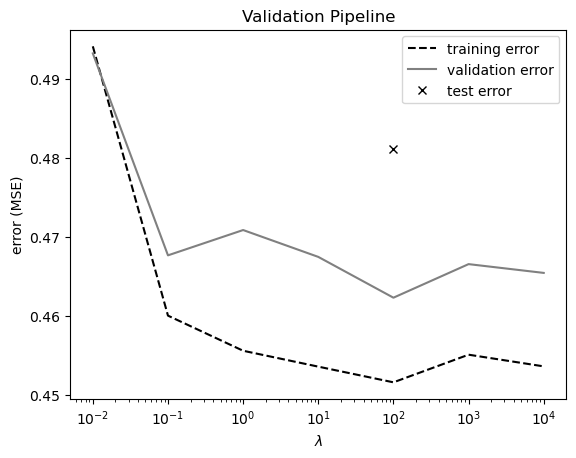

In [130]:
pipeline(2000, False, False)

In [3]:
lowestMSE = 0.46231221423905944

## Sentiment Analysis combined with Linear Regression Model

### Bag-of-words

In [21]:
rf = defaultdict(int)
bd = defaultdict(int)

for d in data:    
    rf[d['rented for']] += 1
    bd[d['body type']] += 1

bddict = bd.keys()
rfdict = rf.keys()
bddict = dict(zip(list(bddict),range(len(bddict))))
rfdict = dict(zip(list(rfdict),range(len(rfdict))))

In [22]:
wordCount = defaultdict(int)
for d in data:
    r = ''.join([c for c in d['review_text'].lower() if not c in sp])
    for w in r.split():
        wordCount[w] += 1

len(wordCount)

44407

In [23]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()
words = [x[1] for x in counts[:1000]]

### Sentiment analysis

In [24]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [25]:
def feat(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review_text'].lower() if not c in sp])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

In [26]:
X = [feat(d) for d in data]
y = [d['rating'] for d in data]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, random_state=42)

In [27]:
# Linear regression
clf = linear_model.LinearRegression(fit_intercept=False)
clf.fit(Xtrain, ytrain)
theta = clf.coef_
ypred = clf.predict(Xtest)
mse = mean_squared_error(ytest, ypred)

In [28]:
mse

0.3800427246055563

In [29]:
def feat1(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review_text'].lower() if not c in sp])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1

    feat.append(bddict[datum['body type']])
    
    feat.append(1) # offset
    return feat

In [30]:
X2 = [feat1(d) for d in data]
y2 = [d['rating'] for d in data]

Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X2, y2, test_size=0.5, random_state=42)

In [31]:
# Linear regression
clf2 = linear_model.LinearRegression(fit_intercept=False)
clf2.fit(Xtrain2, ytrain2)
theta2 = clf2.coef_
ypred2 = clf2.predict(Xtest2)
mse2 = mean_squared_error(ytest2, ypred2)

In [32]:
mse2

0.38005061145625113

In [33]:
categoryCounts = defaultdict(int)
for d in data:
    categoryCounts[d['category']] += 1
categories = [c for c in categoryCounts if categoryCounts[c] > 1000]
catID = dict(zip(list(categories),range(len(categories))))
catID

{'romper': 0,
 'gown': 1,
 'dress': 2,
 'sheath': 3,
 'jacket': 4,
 'jumpsuit': 5,
 'shift': 6,
 'top': 7,
 'mini': 8,
 'skirt': 9,
 'maxi': 10}

In [34]:
def feat2(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review_text'].lower() if not c in sp])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    
    feat.append(bddict[datum['body type']])
    
    feat1 = [0] * len(catID)
    if d['category'] in catID:
        feat1[catID[d['category']]] = 1
    feat.extend(feat1)
    
    feat.append(1) # offset
    return feat

In [35]:
X3 = [feat2(d) for d in data]
y3 = [d['rating'] for d in data]

In [36]:
Xtrain3, Xtest3, ytrain3, ytest3 = train_test_split(X3, y3, test_size=0.5, random_state=42)

In [37]:
# Linear regression
clf3 = linear_model.LinearRegression(fit_intercept=False)
clf3.fit(Xtrain3, ytrain3)
theta3 = clf3.coef_
ypred3 = clf3.predict(Xtest3)
mse3 = mean_squared_error(ytest3, ypred3)
mse3

0.38005061145625113

In [38]:
rfdict, bddict

({'vacation': 0,
  'other': 1,
  'formal affair': 2,
  'wedding': 3,
  'date': 4,
  'everyday': 5,
  'party': 6,
  'work': 7,
  'party: cocktail': 8},
 {'hourglass': 0,
  'straight & narrow': 1,
  'pear': 2,
  'athletic': 3,
  'full bust': 4,
  'petite': 5,
  'apple': 6})

In [39]:
def feat3(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review_text'].lower() if not c in sp])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    
    feat.append(bddict[datum['body type']])
    feat.append(rfdict[datum['rented for']])
    
    feat1 = [0] * len(catID)
    if d['category'] in catID:
        feat1[catID[d['category']]] = 1
    feat.extend(feat1)
    
    feat.append(1) # offset
    return feat

In [40]:
X4 = [feat3(d) for d in data]
y4 = [d['rating'] for d in data]

Xtrain4, Xtest4, ytrain4, ytest4 = train_test_split(X4, y4, test_size=0.5, random_state=42)

In [41]:
# Linear regression
clf4 = linear_model.LinearRegression(fit_intercept=False)
clf4.fit(Xtrain4, ytrain4)
theta4 = clf4.coef_
ypred4 = clf4.predict(Xtest4)
mse4 = mean_squared_error(ytest4, ypred4)
mse4

0.3795129310637153

In [42]:
def feat5(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review_text'].lower() if not c in sp])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    
    feat.append(datum['size'])
    feat.append(datum['age'])
    feat.append(bddict[datum['body type']])
    feat.append(rfdict[datum['rented for']])
    
    feat1 = [0] * len(catID)
    if d['category'] in catID:
        feat1[catID[d['category']]] = 1
    feat.extend(feat1)
    
    feat.append(1) # offset
    return feat

In [43]:
X5 = [feat5(d) for d in data]
y5 = [d['rating'] for d in data]

Xtrain5, Xtest5, ytrain5, ytest5 = train_test_split(X5, y5, test_size=0.5, random_state=42)

In [44]:
# Linear regression
clf5 = linear_model.LinearRegression(fit_intercept=False)
clf5.fit(Xtrain5, ytrain5)
theta5 = clf5.coef_
ypred5 = clf5.predict(Xtest5)
mse5 = mean_squared_error(ytest5, ypred5)
mse5

0.3792900044700947

In [48]:
theta, theta2, theta3, theta4, theta5

(array([ 2.00869738e-05,  6.20751706e-03, -7.22092925e-04, ...,
        -1.87766454e-01,  1.04804027e-02,  4.43649486e+00]),
 array([ 2.23259023e-05,  6.21434266e-03, -7.15807543e-04, ...,
         1.05136877e-02,  5.64300183e-04,  4.43520656e+00]),
 array([ 2.23259023e-05,  6.21434266e-03, -7.15807543e-04, ...,
         0.00000000e+00,  0.00000000e+00,  2.21760328e+00]),
 array([-2.83855914e-04,  6.10509585e-03, -7.49936657e-04, ...,
         0.00000000e+00,  0.00000000e+00, -2.13395111e+11]),
 array([-3.34997981e-05,  6.41418518e-03, -4.80292743e-04, ...,
         0.00000000e+00,  0.00000000e+00,  2.28755433e+00]))

In [49]:
def feat6(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review_text'].lower() if not c in sp])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    
    feat.append(datum['height'])
    feat.append(datum['weight'])
    feat.append(datum['size'])
    feat.append(datum['age'])
    feat.append(bddict[datum['body type']])
    feat.append(rfdict[datum['rented for']])
    
    feat1 = [0] * len(catID)
    if d['category'] in catID:
        feat1[catID[d['category']]] = 1
    feat.extend(feat1)
    
    feat.append(1) # offset
    return feat

In [50]:
X6 = [feat6(d) for d in data]
y6 = [d['rating'] for d in data]

Xtrain6, Xtest6, ytrain6, ytest6 = train_test_split(X6, y6, test_size=0.5, random_state=42)

In [51]:
# Linear regression
clf6 = linear_model.LinearRegression(fit_intercept=False)
clf6.fit(Xtrain6, ytrain6)
theta6 = clf6.coef_
ypred6 = clf6.predict(Xtest6)
mse6 = mean_squared_error(ytest6, ypred6)
mse6

0.3793218517375521